In [4]:
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install "tf-models-official==2.13.*"

#https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

In [1]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset,DatasetDict
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from utils import save_confusion_matrices
#from official.nlp import optimization
random_state=42
seed=812
#MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
#MODEL_NAME = 'distilbert-base-cased'
MODEL_NAME= 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def reverse_mapping(preds):
    mapping={
        0:"DECEPTIVENEGATIVE",
        1:"DECEPTIVEPOSITIVE",
        2:"TRUTHFULNEGATIVE",
        3:"TRUTHFULPOSITIVE",
    }
    return [mapping[pred] for pred in preds]

def label_mapping(example):
    mapping={
        "DECEPTIVENEGATIVE":0,
        "DECEPTIVEPOSITIVE":1,
        "TRUTHFULNEGATIVE":2,
        "TRUTHFULPOSITIVE":3,
    }
    return {"labels":mapping[example["labels"]]}


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def train_pre_processing(txt_file):
  df=pd.read_csv(txt_file,sep="\t",names=["LABEL","REVIEW"])
  X_train, X_test, y_train, y_test = train_test_split( df["REVIEW"].to_list(),df["LABEL"].to_list(), test_size=0.2, random_state=random_state)
  print(X_test[0])
  train_dataset=Dataset.from_dict({"text":X_train,"labels":y_train})
  test_dataset=Dataset.from_dict({"text":X_test,"labels":y_test})
  dataset=DatasetDict({"train":train_dataset,"test":test_dataset})
  dataset=dataset.map(label_mapping,batched=False)
  tokenized_datasets = dataset.map(tokenize_function, batched=True)
  tokenized_datasets = tokenized_datasets.remove_columns(["text"])
  return tokenized_datasets,X_test

def test_pre_processing(txt_file):
  with open(txt_file, "r") as file:
      content = file.read()
  content=content.splitlines()
  df=pd.DataFrame(content,columns=["REVIEW"])
  dataset = Dataset.from_pandas(df)
  dataset=dataset.rename_columns({"REVIEW":"text"})
  tokenized_datasets = dataset.map(tokenize_function, batched=True)
  tokenized_datasets = tokenized_datasets.remove_columns(["text"])
  return tokenized_datasets

def get_predictions(model,dataset):
  preds=model.predict(dataset)
  return np.argmax(preds.logits,axis=1)


#tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
#tokenized_datasets["test"] = tokenized_datasets["test"].shuffle(seed=42).select(range(10))

c:\Users\Tiago\anaconda3\envs\mlproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification
from transformers import DefaultDataCollator
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np
#from official.nlp import optimization
from sklearn.metrics import accuracy_score



tf.keras.utils.set_random_seed(seed)

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)

batch_size=8
epochs=6

data_collator = DefaultDataCollator(return_tensors="tf")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
tokenized_datasets,X_test=train_pre_processing("train.txt")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_validation_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

The Omni Chicago Hotel I am a business woman who travels a great deal out of a month, therefore, my accommodations must meet the highest standards. I was booked for a stay at The Omni Chicago Hotel, located in what is referred to as ' The Magnificent Mile ' in the greater Chicago area. ' Magnificent ', it was! The beautifully red-bricked sky scraper was indeed a breath- taking sight and upon entrance, I had a felling of warmth from the very hospitable welcoming staff. I was impressed with the hotels special rates offered during prime business hours and the guest rooms ranged everything from ' The Presidential Suite to The Governors Suite '. I accepted a more humble room as I would not need to spend very much time there during the day. I did stay inside most nights and the amenities were more than satisfactory. I enjoyed the very spacious exercise room and afterwards, I would take a quick dip in the pool. I toured the hotel as my niece is planning her wedding and just so happens to live

Map: 100%|██████████| 280/280 [00:00<00:00, 314.71 examples/s]


In [35]:
steps_per_epoch = tf.data.experimental.cardinality(tf_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(
    #optimizer=tf.keras.optimizers.AdamW(init_lr),
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

# loss, acc=model.evaluate(tf_validation_dataset)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


In [8]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66956548 (255.42 MB)
Trainable params: 66956548 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
import os
optimizer_type='customized'
#optimizer_type='adamW'
save_model_dir=os.path.join(os.getcwd(),f"model_seed_{seed}_epcs_{epochs}_bs_{batch_size}_lr_{init_lr}_opt_{optimizer_type}")
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
             tf.keras.callbacks.ModelCheckpoint(filepath=save_model_dir, monitor='val_loss',save_best_only=True,save_weights_only=True)]
H=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=epochs,callbacks=callbacks)

Epoch 1/6


In [14]:
saved_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [16]:
saved_model.load_weights("saved_models/c_seed_900_089/c_model_seed_900_epcs_6_bs_8_lr_3e-05_opt_customized")

In [17]:
preds=get_predictions(saved_model,tf_validation_dataset)

35/35 [==============================] - 212s 6s/step


In [4]:
#preds_labels=reverse_mapping(preds)
y_true=reverse_mapping(tokenized_datasets["test"]["labels"])
y_true=np.save("val_true_labels.npy",np.array(y_true))
#preds_labels=reverse_mapping(preds)

In [5]:
preds_labels=np.load("validation_preds_dense.npy")
y_true=np.load("val_true_labels.npy")

In [6]:
accuracy_score(y_true,preds_labels)

0.8892857142857142

In [34]:
np.save("validation_preds_dense",preds_labels)
df=pd.DataFrame()
df=pd.DataFrame({"Predicted":preds_labels,"True":y_true,"Reviews":X_test})
df.to_csv("outputs/predictions_dense.tsv",sep="\t",index=False)

In [53]:
y_true,preds_labels,X_test=np.array(y_true),np.array(preds_labels),np.array(X_test)
error_index=y_true!=preds_labels
df_test=pd.DataFrame({"Predicted":np.array(preds_labels)[error_index],"True":np.array(y_true)[error_index],"Reviews":X_test[error_index]})
df_test.to_csv("outputs/errors_dense.tsv",sep="\t",index=False)

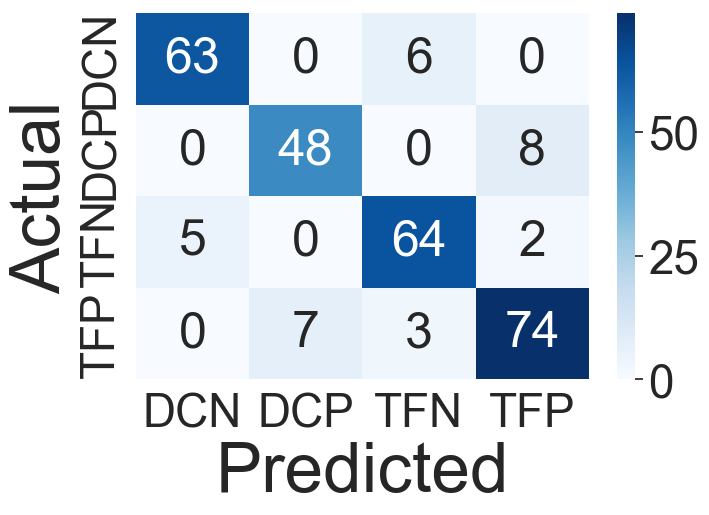

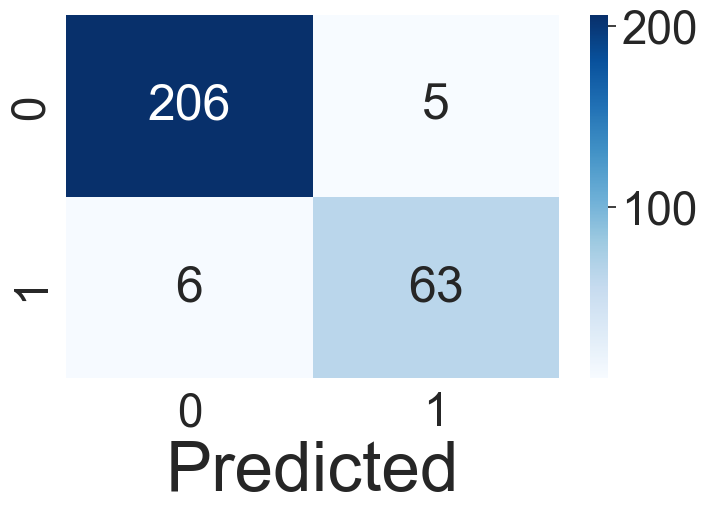

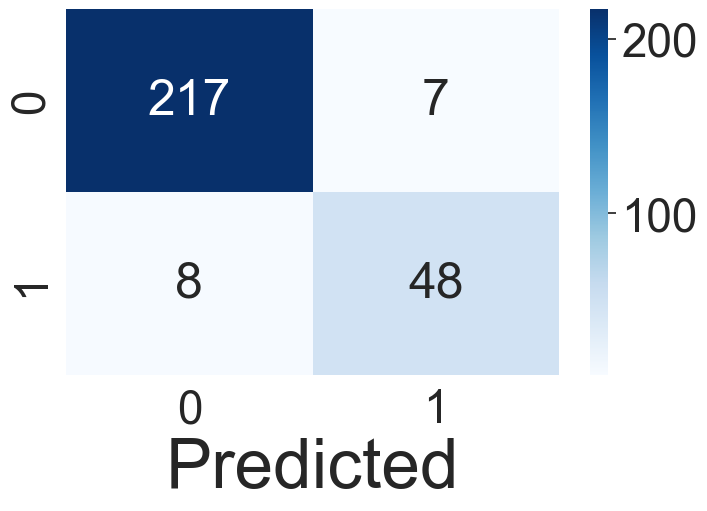

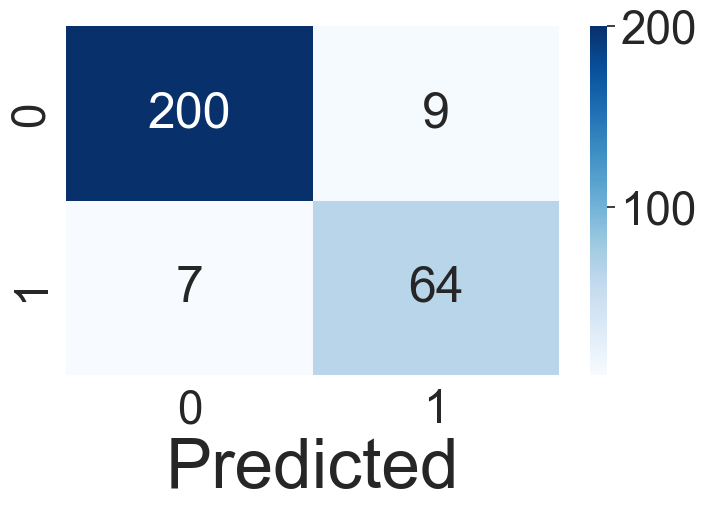

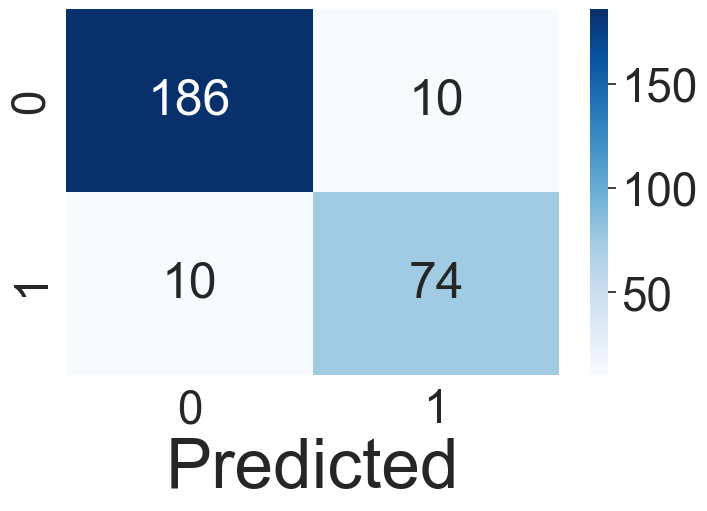

In [7]:
# accuracy_score(tokenized_datasets["test"]["labels"],preds)
from utils import save_confusion_matrices
# preds=reverse_mapping(preds)
save_confusion_matrices(y_true,preds_labels,model_name='dense')

In [21]:
from utils import save_confusion_matrices,save_acc_per_label
save_acc_per_label(y_true,preds_labels,'dense_cased')

[[206   5]
 [  9  60]]
[[197  27]
 [  3  53]]
[[201   8]
 [ 11  60]]
[[188   8]
 [ 25  59]]
{'DECEPTIVENEGATIVE': [0.95], 'DECEPTIVEPOSITIVE': [0.893], 'TRUTHFULNEGATIVE': [0.932], 'TRUTHFULPOSITIVE': [0.882]}
Done


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


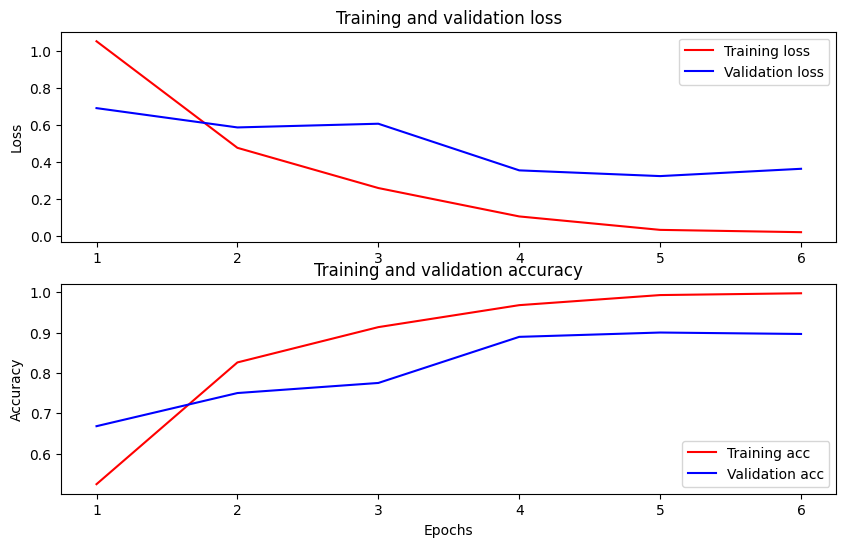

In [16]:
# history_dict = H.history
# print(history_dict.keys())

# acc = history_dict['sparse_categorical_accuracy']
# val_acc = history_dict['val_sparse_categorical_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
# fig = plt.figure(figsize=(10, 6))
# fig.tight_layout()

# plt.subplot(2, 1, 1)
# # r is for "solid red line"
# plt.plot(epochs, loss, 'r', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# # plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

In [ ]:
print(tf_validation_dataset)

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [6]:
import pandas as pd
import os

In [16]:
test_tokenized=test_pre_processing("test_just_reviews.txt")

tf_test_dataset = test_tokenized.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

Map: 100%|██████████| 200/200 [00:00<00:00, 314.22 examples/s]


In [17]:
preds=get_predictions(saved_model,tf_test_dataset)

25/25 [==============================] - 120s 5s/step


In [18]:
preds_labels=reverse_mapping(preds)
np.save("test_labels",np.array(preds_labels))
#np.load("test_labels.npy")


In [19]:
with open("test_just_reviews.txt", "r") as file:
    content = file.read()
content=content.splitlines()
df=pd.DataFrame(content,columns=["REVIEWS"])
df["LABEL"]=preds_labels
df= df.loc[:, ::-1] 
df.to_csv("test_reviews_and_labels.csv",sep="\t",index=False)
df["LABEL"].to_csv("test_reviews_labels_submission.txt",index=False,header=False)